In [3]:
from easy21 import *
import numpy as np

- Apply Monte-Carlo control to Easy21. 
- [x] Initialise the value function to zero. 
- [x] Use a time-varying scalar step-size of αt = 1/N(st,at) 
- [x] and an ε-greedy exploration strategy with εt = N0/(N0 + N(st)), 
- [x] where N0 = 100 is a constant, 
- [x] N(s) is the number of times that state s has been visited, 
- [x] and N(s,a) is the number of times that action a has been selected from state s. 
- [x] Feel free to choose an alternative value for N0, if it helps producing better results. 
- [x] Plot the optimal value function V ∗ (s) = maxa Q∗ (s, a) using similar axes to the following figure taken from Sutton and Barto’s Blackjack example.

In [4]:
class MC_Agent:
    def __init__(self, environment, n0):
        self.n0 = float(n0)
        self.env = environment
        
        # N(s) is the number of times that state s has been visited
        # N(s,a) is the number of times that action a has been selected from state s.
        self.N = np.zeros((self.env.dealer_values_count,
                           self.env.player_values_count, 
                           self.env.actions_count))
        
        self.Q = np.zeros((self.env.dealer_values_count,
                           self.env.player_values_count, 
                           self.env.actions_count))
        # self.E = np.zeros((self.env.dealer_values_count,
        #                    self.env.player_values_count, 
        #                    self.env.actions_count))

        # Initialise the value function to zero. 
        self.V = np.zeros((self.env.dealer_values_count, self.env.player_values_count))
        
        self.count_wins = 0
        self.iterations = 0

#     def get_action(self, s):
#         a = Actions.hit
#         return a
    
        # get optimal action, with epsilon exploration (epsilon dependent on number of visits to the state)
    # ε-greedy exploration strategy with εt = N0/(N0 + N(st)), 
    def get_action(self, state):
        dealer_idx = state.dealer-1
        player_idx = state.player-1
        n_visits = sum(self.N[dealer_idx, player_idx, :])

        # epsilon = N0/(N0 + N(st)
        curr_epsilon = self.n0 / (self.n0 + n_visits)

        # epsilon greedy policy
        if random.random() < curr_epsilon:
            r_action = Actions.hit if random.random()<0.5 else Actions.stick
#             if (dealer_idx == 0 and player_idx == 0):
#                 print ("epsilon:%s, random:%s " % (curr_epsilon, r_action))
            return r_action
        else:
            action = Actions.to_action(np.argmax(self.Q[dealer_idx, player_idx, :]))
#             if (dealer_idx == 0 and player_idx == 0):
#                 print ("epsilon:%s Qvals:%s Q:%s" % (curr_epsilon, self.Q[dealer_idx, player_idx, :], action))
            return action

    def train(self, iterations):        
        
        # Loop episodes
        for episode in xrange(iterations):
            episode_pairs = []
            
            # get initial state for current episode
            s = self.env.get_start_state()
            
            # Execute until game ends
            while not s.term:
                
                # get action with epsilon greedy policy
                a = self.get_action(s)
                
                # store action state pairs
                episode_pairs.append((s, a))
                
                # update visits
                # N(s) is the number of times that state s has been visited
                # N(s,a) is the number of times that action a has been selected from state s. 
                self.N[s.dealer-1, s.player-1, Actions.as_int(a)] += 1
                
                # execute action
                s,r = self.env.step(s, a)

            #if episode%10000==0: print "Episode: %d, Reward: %d" %(episode, my_state.rew)
            self.count_wins = self.count_wins+1 if r==1 else self.count_wins

            # Update Action value function accordingly
            for curr_s, curr_a in episode_pairs:
                # print s.dealer, s.player, s.r, a
                dealer_idx = curr_s.dealer-1
                player_idx = curr_s.player-1
                action_idx = Actions.as_int(curr_a)
                
                # Use a time-varying scalar step-size of αt = 1/N(st,at) 
#                 step = 1.0 / sum(self.N[dealer_idx, player_idx, :])
                step = 1.0 / self.N[dealer_idx, player_idx, action_idx]
                error = r - self.Q[dealer_idx, player_idx, action_idx]
                self.Q[dealer_idx, player_idx, action_idx] += step * error

        self.iterations += iterations
        print float(self.count_wins)/self.iterations*100

        # Derive value function
        for d in xrange(self.env.dealer_values_count):
            for p in xrange(self.env.player_values_count):
                self.V[d,p] = max(self.Q[d, p, :])
                
    def plot_frame(self, ax):
        def get_stat_val(x, y):
            return self.V[x, y]

        X = np.arange(0, self.env.dealer_values_count, 1)
        Y = np.arange(0, self.env.player_values_count, 1)
        X, Y = np.meshgrid(X, Y)
        Z = get_stat_val(X, Y)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        return surf

# TODO 
#  add missing values
#  make train so it can be ran multiple sets of itteractions
#   (and figure out when to compute the value function and to make sure its done from start of file

In [40]:
# where N0 = 100 is a constant, 
N0 = 100

In [49]:
N0 = 100
agent = MC_Agent(Environment(), N0)
for i in xrange (10):
    agent.train(50000)

50.204
50.868
51.272
51.454
51.6076
51.7306666667
51.7154285714
51.8225
51.8557777778
51.9162


In [5]:
# Feel free to choose an alternative value for N0, if it helps producing better results.

In [6]:
# N0 = 300
# agent = MC_Agent(Environment(), N0)
# for i in xrange (10):
#     agent.train(50000)

In [7]:
# N0 = 30
# agent = MC_Agent(Environment(), N0)
# for i in xrange (10):
#     agent.train(50000)

## Plot

In [138]:
def animate(frame):
    i = agent.iterations
    step_size = i
    step_size = max(1, step_size)
    step_size = min(step_size, 2 ** 16)
    agent.train(step_size)

    ax.clear()
    surf =  agent.plot_frame(ax)
    plt.title('MC score:%s frame:%s step_size:%s ' % (float(agent.count_wins)/agent.iterations*100, frame, step_size) )
    # plt.draw()
    fig.canvas.draw()
    print "done ", frame, step_size, i
    return surf

100.0
done  0 1 0
50.0
done  0 1 1
50.0
done  1 2 2
50.0
done  2 4 4
43.75
done  3 8 8
37.5
done  4 16 16
32.8125
done  5 32 32
41.40625
done  6 64 64
46.09375
done  7 128 128
41.796875
done  8 256 256
44.23828125
done  9 512 512
46.58203125
done  10 1024 1024
46.1669921875
done  11 2048 2048
46.826171875
done  12 4096 4096
48.4375
done  13 8192 8192
49.4934082031
done  14 16384 16384
50.6240844727
done  15 32768 32768
51.2351989746
done  16 65536 65536
51.486714681
done  17 65536 131072
51.5937805176
done  18 65536 196608
51.7282104492
done  19 65536 262144
51.7868041992
done  20 65536 327680
51.8537248884
done  21 65536 393216
51.873588562
done  22 65536 458752
51.9407484266
done  23 65536 524288
51.943359375
done  24 65536 589824
51.962557706
done  25 65536 655360
51.9667307536
done  26 65536 720896
51.976952186
done  27 65536 786432
52.0238603864
done  28 65536 851968
52.0373535156
done  29 65536 917504
52.0481109619
done  30 65536 983040
52.0564359777
done  31 65536 1048576
52.055

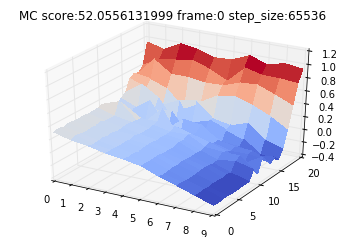

In [139]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 100
agent = MC_Agent(Environment(), N0)
fig = plt.figure("N100")
ax = fig.add_subplot(111, projection='3d')

ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent.gif', writer='imagemagick', fps=3)
# plt.show()

In [140]:
from IPython.display import Image
Image(url="MC_Agent.gif")

In [11]:
# Feel free to choose an alternative value for N0, if it helps producing better results.

0.0
done  0 1 0
50.0
done  0 1 1
25.0
done  1 2 2
50.0
done  2 4 4
50.0
done  3 8 8
37.5
done  4 16 16
42.1875
done  5 32 32
39.0625
done  6 64 64
41.40625
done  7 128 128
43.1640625
done  8 256 256
44.23828125
done  9 512 512
44.384765625
done  10 1024 1024
44.140625
done  11 2048 2048
44.7998046875
done  12 4096 4096
45.0378417969
done  13 8192 8192
44.9829101562
done  14 16384 16384
45.0775146484
done  15 32768 32768
44.8692321777
done  16 65536 65536
44.8455810547
done  17 65536 131072
44.8455810547
done  18 65536 196608
44.7933959961
done  19 65536 262144
44.8120117188
done  20 65536 327680
44.8218209403
done  21 65536 393216
44.8207855225
done  22 65536 458752
44.7991265191
done  23 65536 524288
44.7988891602
done  24 65536 589824
44.8039661754
done  25 65536 655360
44.8243459066
done  26 65536 720896
44.8088425856
done  27 65536 786432
44.8173522949
done  28 65536 851968
44.831644694
done  29 65536 917504
44.8227882385
done  30 65536 983040
44.836695054
done  31 65536 1048576
44

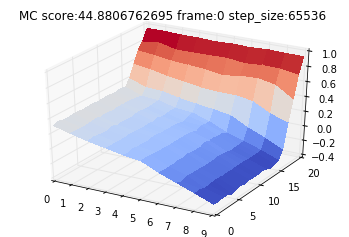

In [134]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 1000000
agent = MC_Agent(Environment(), N0)
fig = plt.figure("N1000000")
ax = fig.add_subplot(111, projection='3d')

ani = animation.FuncAnimation(fig, animate, 50, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent_N1000000.gif', writer='imagemagick', fps=3)
# plt.show()

In [135]:
from IPython.display import Image
Image(url="MC_Agent_N1000000.gif")

0.0
done  0 1 0
50.0
done  0 1 1
50.0
done  1 2 2
50.0
done  2 4 4
37.5
done  3 8 8
43.75
done  4 16 16
50.0
done  5 32 32
46.09375
done  6 64 64
44.53125
done  7 128 128
44.53125
done  8 256 256
46.09375
done  9 512 512
47.265625
done  10 1024 1024
47.3388671875
done  11 2048 2048
48.3642578125
done  12 4096 4096
49.1149902344
done  13 8192 8192
49.4354248047
done  14 16384 16384
49.6887207031
done  15 32768 32768
49.7673034668
done  16 65536 65536
50.0111897786
done  17 65536 131072
50.0957489014
done  18 65536 196608
50.0939941406
done  19 65536 262144
50.1243591309
done  20 65536 327680
50.1347133092
done  21 65536 393216
50.1184463501
done  22 65536 458752
50.0944349501
done  23 65536 524288
50.075378418
done  24 65536 589824
50.0894719904
done  25 65536 655360
50.0904083252
done  26 65536 720896
50.0821627103
done  27 65536 786432
50.0813075474
done  28 65536 851968
50.0719197591
done  29 65536 917504
50.083732605
done  30 65536 983040
50.0952327953
done  31 65536 1048576
50.0992

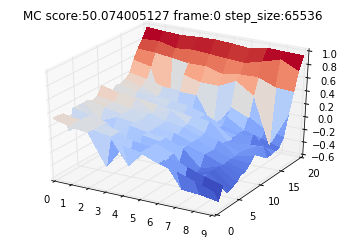

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 1
agent = MC_Agent(Environment(), N0)
fig = plt.figure("N1")
ax = fig.add_subplot(111, projection='3d')

ani = animation.FuncAnimation(fig, animate, 50, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent_N1.gif', writer='imagemagick', fps=3)
# plt.show()

In [15]:
from IPython.display import Image
Image(url="MC_Agent_N1.gif")

0.0
done  0 1 0
50.0
done  0 1 1
50.0
done  1 2 2
25.0
done  2 4 4
25.0
done  3 8 8
34.375
done  4 16 16
45.3125
done  5 32 32
39.0625
done  6 64 64
36.328125
done  7 128 128
40.625
done  8 256 256
43.26171875
done  9 512 512
43.017578125
done  10 1024 1024
44.384765625
done  11 2048 2048
45.0439453125
done  12 4096 4096
45.3369140625
done  13 8192 8192
46.2921142578
done  14 16384 16384
47.2717285156
done  15 32768 32768
48.3474731445
done  16 65536 65536
48.8789876302
done  17 65536 131072
49.3667602539
done  18 65536 196608
49.6713256836
done  19 65536 262144
49.9188741048
done  20 65536 327680
50.0823974609
done  21 65536 393216
50.2656936646
done  22 65536 458752
50.3904554579
done  23 65536 524288
50.5033874512
done  24 65536 589824
50.5722045898
done  25 65536 655360
50.6757100423
done  26 65536 720896
50.7508497972
done  27 65536 786432
50.8113316127
done  28 65536 851968
50.8758544922
done  29 65536 917504
50.9147644043
done  30 65536 983040
50.9786269244
done  31 65536 104857

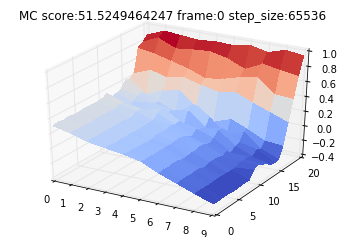

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

N0 = 1000
agent = MC_Agent(Environment(), N0)
fig = plt.figure("Nbest")
ax = fig.add_subplot(111, projection='3d')

ani = animation.FuncAnimation(fig, animate, 50, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('MC_Agent_Nbest.gif', writer='imagemagick', fps=3)
# plt.show()

In [21]:
from IPython.display import Image
Image(url="MC_Agent_Nbest.gif")

In [66]:
# Actions.as_int(value)
agent.V[9, 1]

-0.29257299627670064

In [142]:
stick_v = np.zeros((agent.env.dealer_values_count, agent.env.player_values_count))
hit_v = np.zeros((agent.env.dealer_values_count, agent.env.player_values_count))
actions = np.zeros((agent.env.dealer_values_count, agent.env.player_values_count))
for d in xrange(agent.env.dealer_values_count):
    for p in xrange(agent.env.player_values_count):
        action = Actions.to_action(np.argmax(agent.Q[d, p, :]))
        value = agent.V[d, p]
        if (action == Actions.stick):
            stick_v[d,p] = value
            hit_v[d,p] = 0
            actions[d,p] = -1
        else:
            hit_v[d,p] = value
            stick_v[d,p] = 0
            actions[d,p] = 1

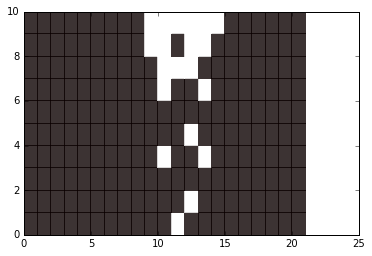

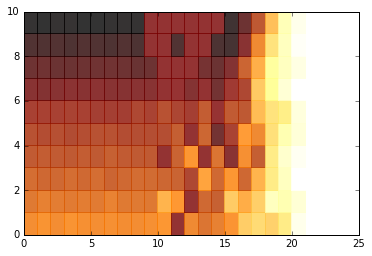

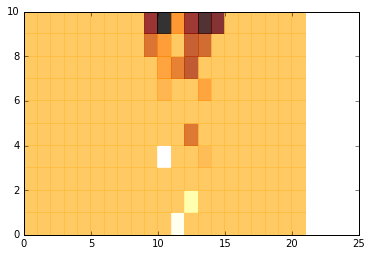

In [144]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

# fig = plt.figure("N100")
# ax = fig.add_subplot()
# bx = fig.add_subplot()
fig, ax = plt.subplots()
fig2, bx = plt.subplots()
fig3, cx = plt.subplots()
heatmap3 = ax.pcolor(actions, cmap=plt.cm.hot, alpha=0.8)
heatmap = bx.pcolor(stick_v, cmap=plt.cm.afmhot, alpha=0.8)
heatmap2 = cx.pcolor(hit_v, cmap=plt.cm.afmhot, alpha=0.8)
plt.show()